# Customer Churn Prediction using XGBoost
### Comparing Encoding Techniques: Binary vs Label vs One-Hot
This project explores the impact of different encoding strategies on model performance using the Telco Customer Churn dataset.

## 1.Necessary Libraries

In [249]:
#Baasic Libraries
import pandas as pd
import numpy as np

#For Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For GPU-based ML
import xgboost as xgb

# ML + Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [250]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [251]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


### Model Performance Class

In [252]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

class ModelResult:
    def __init__(self, name):
        self.name = name
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.report = None
        self.confusion_matrix = None
    
    def evaluate(self, y_true, y_pred):
        self.accuracy = accuracy_score(y_true, y_pred)
        self.precision = precision_score(y_true, y_pred)
        self.recall = recall_score(y_true, y_pred)
        self.f1 = f1_score(y_true, y_pred)
        self.report = classification_report(y_true, y_pred, output_dict=True)
        self.confusion_matrix = confusion_matrix(y_true, y_pred)
    
    def print_summary(self):
        print(f"📊 Performance of {self.name}")
        print(f"Accuracy  : {self.accuracy:.4f}")
        print(f"Precision : {self.precision:.4f}")
        print(f"Recall    : {self.recall:.4f}")
        print(f"F1 Score  : {self.f1:.4f}")


## 2.Loading Dataset

In [253]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Quick look
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3.Data Cleaning

In [254]:
# Fix TotalCharges: conversion of empty strings
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop customerID as it has no predictive value
df.drop('customerID', axis=1, inplace=True)

# Convert target column 'Churn' to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


## 4. 🧪 Model 1: Binary Encoding

### Preprocessing

In [255]:
binary_df=df.copy()

# Columns with "Yes", "No", "No internet service" / "No phone service"
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace 'No internet service' with 'No' for smooth binary encoding
df[service_cols] = df[service_cols].replace({'No internet service': 'No'})
    
# map all to binary(0 or 1)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'] + service_cols

for col in binary_cols:
    binary_df[col] = binary_df[col].map({'Yes': 1, 'No': 0,'No phone service':0})

# Categorical columns to encode
cat_cols = ['gender', 'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']

binary_df = pd.get_dummies(binary_df, columns=cat_cols, drop_first=False)

# Confirm cleanup
print("Cleaned Data Shape:", df.shape)
df.head()

Cleaned Data Shape: (7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Model Training

In [256]:
# Split features and target
X = binary_df.drop('Churn', axis=1)
y = binary_df['Churn']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for GPU training
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',    # Use CPU-style tree
    'device': 'cuda',         # But train on GPU
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train model
model_allBinary = xgb.train(params, dtrain, num_boost_round=100)

print("✅ Model training complete")


✅ Model training complete


### Model Evaluation

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.62      0.56      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.72      1407
weighted avg       0.78      0.79      0.79      1407

🧮 Confusion Matrix:
[[903 130]
 [166 208]]


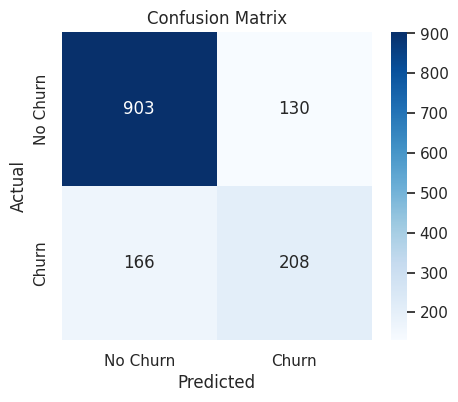

In [257]:
# Predict probabilities on test set
y_pred_prob = model_allBinary.predict(dtest)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("🧮 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Optional: Confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Save Model

In [258]:
#store results
binary_result = ModelResult("Binary Encoding Model")
binary_result.evaluate(y_test, y_pred)
binary_result.print_summary()

model.save_model('xgboost_churn_model_allBinary.json')
print("✅ Model saved to xgboost_churn_model_allBinary.json")

📊 Performance of Binary Encoding Model
Accuracy  : 0.7896
Precision : 0.6154
Recall    : 0.5561
F1 Score  : 0.5843
✅ Model saved to xgboost_churn_model_allBinary.json


### Churn prediction using New data

In [259]:
# Create new customer dict with raw values
new_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.0,
    'TotalCharges': 845.5
}])

# Step 1: Apply same binary encoding as training
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    new_customer[col] = new_customer[col].map({'Yes': 1, 'No': 0})

# Step 2: One-hot encode same categorical columns
categorical_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

# Do one-hot encoding (must match training config)
new_customer_encoded = pd.get_dummies(new_customer, columns=categorical_cols, drop_first=False)

# Step 3: Reindex to match training features
new_customer_encoded = new_customer_encoded.reindex(columns=X_train.columns, fill_value=0)

# Step 4: Convert to DMatrix and predict
new_dmatrix = xgb.DMatrix(new_customer_encoded)
prediction = model_allBinary.predict(new_dmatrix)

# Output result
print("🔮 Churn Probability:", round(float(prediction[0]), 4))
print("🚨 Prediction:", "Churn" if prediction[0] > 0.5 else "No Churn")


🔮 Churn Probability: 0.5215
🚨 Prediction: Churn


## 5. 🧪 Model 2: One-Hot Encoding

### Preprocessing

In [260]:
onehot_df=df.copy()

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
label_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

onehot_cols=binary_cols+label_cols

onehot_df=pd.get_dummies(onehot_df,columns=onehot_cols,drop_first=False)
onehot_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,True,False,True,...,False,True,False,True,False,False,False,False,True,False
1,0,34,56.95,1889.50,0,True,False,True,False,False,...,False,True,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,True,False,False,...,False,True,False,True,False,False,False,False,False,True
3,0,45,42.30,1840.75,0,True,False,True,False,True,...,False,True,False,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False


### Model Training

In [261]:
#Features and target
X = onehot_df.drop('Churn', axis=1)
y = onehot_df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# DMatrix for GPU training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters (GPU-optimized)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)
print("✅ Model trained with label encoding.")


✅ Model trained with label encoding.


### Model Evaluation

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407

🧮 Confusion Matrix:
[[902 131]
 [177 197]]


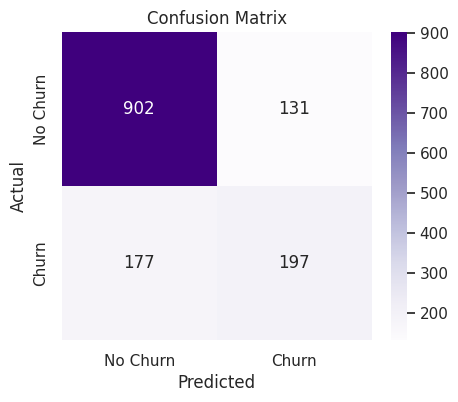

In [262]:
# Predict probabilities on the test set
y_pred_prob = model.predict(dtest)

# Convert to binary labels (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("🧮 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Save Model

In [263]:
#store results 
onehot_result = ModelResult("Onehot Encoding Model")
onehot_result.evaluate(y_test, y_pred)
onehot_result.print_summary()

model.save_model('xgboost_churn_model_allOneHot.json')
print("✅ Model saved to xgboost_churn_model_allOneHot.json")

📊 Performance of Onehot Encoding Model
Accuracy  : 0.7811
Precision : 0.6006
Recall    : 0.5267
F1 Score  : 0.5613
✅ Model saved to xgboost_churn_model_allOneHot.json


### Prediction using New Data

In [264]:
# 👤 New customer input in raw/original form
new_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.0,
    'TotalCharges': 845.5
}])

# 🎯 Step 1: Binary encode 'Yes'/'No' style columns
onehot_cols=binary_cols+label_cols 
new_customer_encoded = pd.get_dummies(new_customer, columns=onehot_cols, drop_first=False)

# 🧩 Step 3: Reindex to match training feature order
new_customer_encoded = new_customer_encoded.reindex(columns=X_train.columns, fill_value=0)

# 🚀 Step 4: Predict using the one-hot encoded model
model = xgb.Booster()
model.load_model('/kaggle/working/xgboost_churn_model_allOneHot.json')

new_dmatrix = xgb.DMatrix(new_customer_encoded)
prediction = model.predict(new_dmatrix)

# 🎉 Step 5: Show result
print("🔮 Churn Probability:", round(float(prediction[0]), 4))
print("🚨 Prediction:", "Churn" if prediction[0] > 0.5 else "No Churn")


🔮 Churn Probability: 0.5741
🚨 Prediction: Churn


## 6. 🧪 Model 3: Label Encoding

### Preprocessing

In [265]:
labelAll_df=df.copy()

cat_cols = df.select_dtypes(include='object').columns.tolist()

# Apply LabelEncoder to each categorical column
le = LabelEncoder()
for col in cat_cols:
    labelAll_df[col] = le.fit_transform(labelAll_df[col])

labelAll_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


### Model training

In [266]:
#Features and target
X = labelAll_df.drop('Churn', axis=1)
y = labelAll_df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# DMatrix for GPU training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters (GPU-optimized)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)
print("✅ Model trained with label encoding.")

✅ Model trained with label encoding.


### Model Evaluation

📄 Classification Report (Label Encoded):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407

🧮 Confusion Matrix:
[[901 132]
 [175 199]]


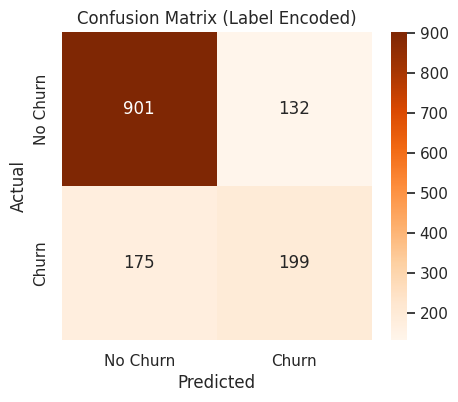

In [267]:
# Predict
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Report
print("📄 Classification Report (Label Encoded):")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("🧮 Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Label Encoded)')
plt.show()


### SAVE MODEL

In [268]:
#store results
label_result = ModelResult("Label Encoding Model")
label_result.evaluate(y_test, y_pred)
label_result.print_summary()

model.save_model('xgboost_churn_model_allLabel.json')
print("✅ Model saved to xgboost_churn_model_allLabel.json")

📊 Performance of Label Encoding Model
Accuracy  : 0.7818
Precision : 0.6012
Recall    : 0.5321
F1 Score  : 0.5645
✅ Model saved to xgboost_churn_model_allLabel.json


### Prediction with New Data

In [269]:
# 👤 New customer input in raw/original form
new_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.0,
    'TotalCharges': 845.5
}])

# 🎯 Step 1: Binary encode 'Yes'/'No' style columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
new_customer_encoded = pd.get_dummies(new_customer, columns=cat_cols, drop_first=False)

# 🧩 Step 3: Reindex to match training feature order
new_customer_encoded = new_customer_encoded.reindex(columns=X_train.columns, fill_value=0)

# 🚀 Step 4: Predict using the one-hot encoded model
model = xgb.Booster()
model.load_model('/kaggle/working/xgboost_churn_model_allLabel.json')

new_dmatrix = xgb.DMatrix(new_customer_encoded)
prediction = model.predict(new_dmatrix)

# 🎉 Step 5: Show result
print("🔮 Churn Probability:", round(float(prediction[0]), 4))
print("🚨 Prediction:", "Churn" if prediction[0] > 0.5 else "No Churn")


🔮 Churn Probability: 0.1918
🚨 Prediction: No Churn


## 7. 🧪 Model 4: Mix

### Preprocessing

In [270]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','gender']
label_cols = [ 'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
onehot_cols=['OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies']

In [271]:
df_encoded=df.copy()
#Binary
for col in binary_cols:
    df_encoded[col]=df_encoded[col].map({'Yes':1,'No':0,'Male':1,'Female':0})

#Label
le=LabelEncoder()
for col in label_cols:
    df_encoded[col]=le.fit_transform(df_encoded[col])

#One-Hot
df_encoded=pd.get_dummies(df_encoded,columns=onehot_cols,drop_first=False)

### Model training

In [272]:
#Features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# DMatrix for GPU training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters (GPU-optimized)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)
print("✅ Model trained with label encoding.")

✅ Model trained with label encoding.


### Model Evaluation

📄 Classification Report (Label Encoded):
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.78      0.78      1407

🧮 Confusion Matrix:
[[903 130]
 [174 200]]


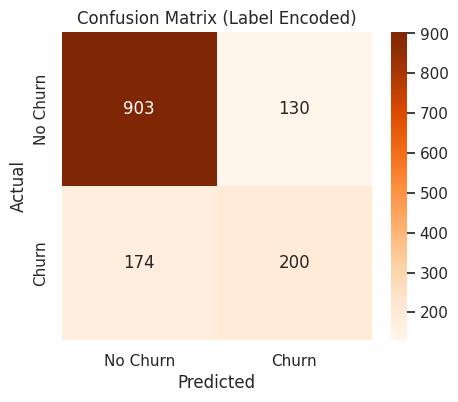

In [273]:
# Predict
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Report
print("📄 Classification Report (Label Encoded):")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("🧮 Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Label Encoded)')
plt.show()


### SAVE MODEL

In [274]:
#store results
mix_result = ModelResult("Mix Encoding Model")
mix_result.evaluate(y_test, y_pred)
mix_result.print_summary()


model.save_model('xgboost_churn_model.json')
print("✅ Model saved to xgboost_churn_model.json")

📊 Performance of Mix Encoding Model
Accuracy  : 0.7839
Precision : 0.6061
Recall    : 0.5348
F1 Score  : 0.5682
✅ Model saved to xgboost_churn_model.json


### Prediction using new Data

In [275]:
# 👤 New customer input in raw/original form
new_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.0,
    'TotalCharges': 845.5
}])

# 🎯 Step 1: Binary encode 'Yes'/'No' style columns
for col in binary_cols:
    new_customer[col]=new_customer[col].map({'Yes':1,'No':0,'Male':1,'Female':0})

#Label
le=LabelEncoder()
for col in label_cols:
    new_customer[col]=le.fit_transform(new_customer[col])

#One-Hot
new_customer=pd.get_dummies(new_customer,columns=onehot_cols,drop_first=False)

# 🧩 Step 3: Reindex to match training feature order
new_customer = new_customer.reindex(columns=X_train.columns, fill_value=0)

# 🚀 Step 4: Predict using the one-hot encoded model
model = xgb.Booster()
model.load_model('/kaggle/working/xgboost_churn_model.json')

new_dmatrix = xgb.DMatrix(new_customer)
prediction = model.predict(new_dmatrix)

# 🎉 Step 5: Show result
print("🔮 Churn Probability:", round(float(prediction[0]), 4))
print("🚨 Prediction:", "Churn" if prediction[0] > 0.5 else "No Churn")


🔮 Churn Probability: 0.1667
🚨 Prediction: No Churn


In [276]:
for col in cat_cols:
    print(f"{col}:", labelAll_df[col].unique())


gender: [0 1]
Partner: [1 0]
Dependents: [0 1]
PhoneService: [0 1]
MultipleLines: [1 0 2]
InternetService: [0 1 2]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: [0 1 2]
PaperlessBilling: [1 0]
PaymentMethod: [2 3 0 1]


## Comparison Plots

In [277]:
results= [binary_result, label_result, onehot_result,mix_result]


model_names = ['Binary','Label','Onehot','Mix']
accuracies = [res.accuracy for res in results]
recalls=[res.recall for res in results]
precisions=[res.precision for res in results]
f1s = [res.f1 for res in results]

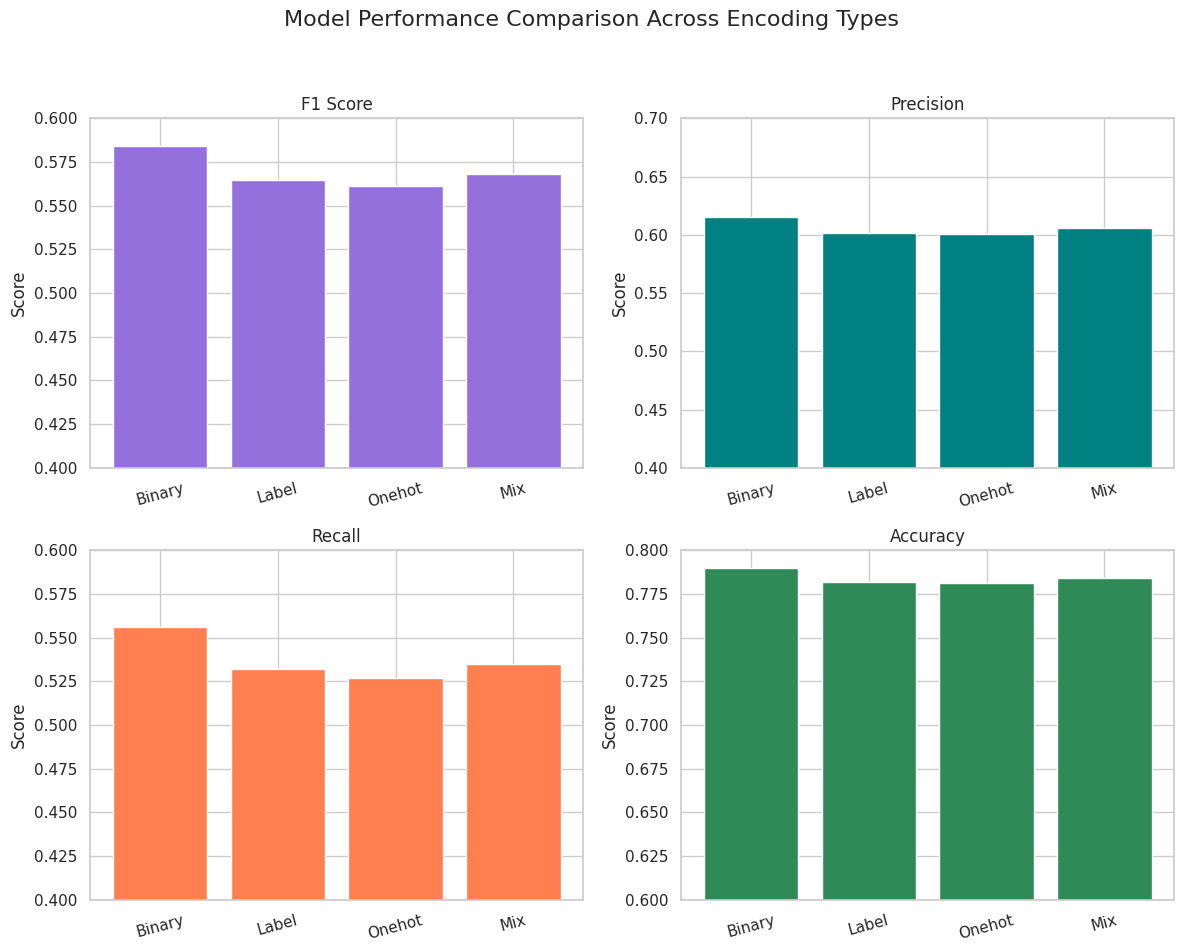

In [278]:
# Create 4 subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Performance Comparison Across Encoding Types', fontsize=16)

# F1 Score
axes[0, 0].bar(model_names, f1s, color='mediumpurple')
axes[0, 0].set_title("F1 Score")
axes[0, 0].set_ylim(0.4, 0.6)
axes[0, 0].set_ylabel("Score")

# Precision
axes[0, 1].bar(model_names, precisions, color='teal')
axes[0, 1].set_title("Precision")
axes[0, 1].set_ylim(0.4, 0.7)
axes[0, 1].set_ylabel("Score")

# Recall
axes[1, 0].bar(model_names, recalls, color='coral')
axes[1, 0].set_title("Recall")
axes[1, 0].set_ylim(0.4, 0.6)
axes[1, 0].set_ylabel("Score")

# Accuracy
axes[1, 1].bar(model_names, accuracies, color='seagreen')
axes[1, 1].set_title("Accuracy")
axes[1, 1].set_ylim(0.6, 0.8)
axes[1, 1].set_ylabel("Score")

# Rotate x-tick labels for better readability
for ax in axes.flatten():
   ax.set_xticks(range(len(model_names)))
   ax.set_xticklabels(model_names, rotation=15)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 📌 Conclusion
### Model Performance vs Encoding Techniques

We evaluated four encoding strategies on the Telco Customer Churn dataset using an XGBoost classifier. The performance metrics for each are:

| **Encoding Type** | **Accuracy** | **Precision** | **Recall** | **F1 Score** |
|-------------------|--------------|---------------|------------|--------------|
| **Binary**        | **0.7896**   | **0.6154**    | **0.5561** | **0.5843**   |
| One-Hot           | 0.7811       | 0.6006        | 0.5267     | 0.5613       |
| Label             | 0.7818       | 0.6012        | 0.5321     | 0.5645       |
| Mixed             | 0.7839       | 0.6061        | 0.5348     | 0.5682       |

---

#### 🔍 Key Observations:
- **Binary encoding outperformed all others** across accuracy, precision, recall, and F1-score.
- **Label and one-hot encoding** yielded similar results, but lagged slightly behind binary.
- **Mixed encoding** (using one-hot, label, and binary selectively) improved over pure one-hot or label, but still didn’t beat full binary.

---

#### ✅ Final Verdict:
For this dataset and model, **binary encoding** provides the best trade-off between dimensionality and predictive power. When categories are truly binary in nature, avoid inflating feature space unnecessarily — let the zeros and ones do their job!
